<a href="https://colab.research.google.com/github/tai-pd/Angular1stDemo.github.io/blob/master/one_transfromer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###1. Clone Oneformer repo

In [ ]:
%cd /content/
!rm -rf OnFormer/
!git clone https://github.com/SHI-Labs/OneFormer-Colab.git
! mv OneFormer-Colab OneFormer
%cd /content/OneFormer/

/content
Cloning into 'OneFormer-Colab'...
remote: Enumerating objects: 141, done.
remote: Counting objects: 100% (141/141), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 141 (delta 35), reused 133 (delta 27), pack-reused 0
Receiving objects: 100% (141/141), 6.71 MiB | 27.25 MiB/s, done.
Resolving deltas: 100% (35/35), done.
/content/OneFormer


In [ ]:
%ls

configs/  images/  oneformer/    README.md         samples/
demo/     LICENSE  packages.txt  requirements.txt  setup.sh


###2. Install dependencies

In [ ]:
## install opencv
!pip3 install -U opencv-python --quiet

## install detectron2
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
!pip3 install natten -f https://shi-labs.com/natten/wheels/cu113/torch1.10.1/index.html --quiet

# ## install dependencies
!pip install git+https://github.com/cocodataset/panopticapi.git --quiet
!pip install git+https://github.com/mcordts/cityscapesScripts.git --quiet

!pip install -r requirements.txt --quiet
!pip install ipython-autotime
!pip install imutils

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-r0nqkzw1
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-r0nqkzw1
  Resolved https://github.com/facebookresearch/detectron2.git to commit 80307d2d5e06f06a8a677cc2653f23a4c56402ac
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 10.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for detectron2: filename=detectron2-0.6-cp310-cp310-linux_x86_64.whl size=5738602 sha256=261dd75de4a39fb0205769cefe0847ed

###3. Import libraries

In [ ]:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
setup_logger(name="oneformer")

# import libraries
import numpy as np
import cv2
import torch
from google.colab.patches import cv2_imshow
import imutils

# Import detectron2 utilities
from detectron2.config import get_cfg
from detectron2.projects.deeplab import add_deeplab_config
from detectron2.data import MetadataCatalog
from demo.defaults import DefaultPredictor
from demo.visualizer import Visualizer, ColorMode


# import OneFormer Project
from oneformer import (
    add_oneformer_config,
    add_common_config,
    add_swin_config,
    add_dinat_config,
    add_convnext_config,
)

###4. Define helper function

In [ ]:
cpu_device = torch.device("cpu")
SWIN_CFG_DICT = {"cityscapes": "configs/cityscapes/oneformer_swin_large_IN21k_384_bs16_90k.yaml",
            "coco": "configs/coco/oneformer_swin_large_IN21k_384_bs16_100ep.yaml",
            "ade20k": "configs/ade20k/oneformer_swin_large_IN21k_384_bs16_160k.yaml",}

DINAT_CFG_DICT = {"cityscapes": "configs/cityscapes/oneformer_dinat_large_bs16_90k.yaml",
            "coco": "configs/coco/oneformer_dinat_large_bs16_100ep.yaml",
            "ade20k": "configs/ade20k/oneformer_dinat_large_IN21k_384_bs16_160k.yaml",}

def setup_cfg(dataset, model_path, use_swin):
    # load config from file and command-line arguments
    cfg = get_cfg()
    add_deeplab_config(cfg)
    add_common_config(cfg)
    add_swin_config(cfg)
    add_dinat_config(cfg)
    add_convnext_config(cfg)
    add_oneformer_config(cfg)
    if use_swin:
      cfg_path = SWIN_CFG_DICT[dataset]
    else:
      cfg_path = DINAT_CFG_DICT[dataset]
    cfg.merge_from_file(cfg_path)
    cfg.MODEL.DEVICE = 'cpu'
    cfg.MODEL.WEIGHTS = model_path
    cfg.freeze()
    return cfg

def setup_modules(dataset, model_path, use_swin):
    cfg = setup_cfg(dataset, model_path, use_swin)
    predictor = DefaultPredictor(cfg)
    metadata = MetadataCatalog.get(
        cfg.DATASETS.TEST_PANOPTIC[0] if len(cfg.DATASETS.TEST_PANOPTIC) else "__unused"
    )
    if 'cityscapes_fine_sem_seg_val' in cfg.DATASETS.TEST_PANOPTIC[0]:
        from cityscapesscripts.helpers.labels import labels
        stuff_colors = [k.color for k in labels if k.trainId != 255]
        metadata = metadata.set(stuff_colors=stuff_colors)

    return predictor, metadata

def panoptic_run(img, predictor, metadata):
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, instance_mode=ColorMode.IMAGE)
    predictions = predictor(img, "panoptic")
    panoptic_seg, segments_info = predictions["panoptic_seg"]
    out = visualizer.draw_panoptic_seg_predictions(
    panoptic_seg.to(cpu_device), segments_info, alpha=0.5
)
    return out

def instance_run(img, predictor, metadata):
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, instance_mode=ColorMode.IMAGE)
    predictions = predictor(img, "instance")
    instances = predictions["instances"].to(cpu_device)
    out = visualizer.draw_instance_predictions(predictions=instances, alpha=0.5)
    return out

def semantic_run(img, predictor, metadata):
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, instance_mode=ColorMode.IMAGE)
    predictions = predictor(img, "semantic")
    out = visualizer.draw_sem_seg(
        predictions["sem_seg"].argmax(dim=0).to(cpu_device), alpha=0.5
    )
    return out

TASK_INFER = {"panoptic": panoptic_run,
              "instance": instance_run,
              "semantic": semantic_run}

In [ ]:
######
#@markdown We use `DiNAT-L` as the default backbone. To use Swin-L as backbone, select the checkbox below.
use_swin = True #@param {type: 'boolean'}

In [ ]:
######
#@title A. Initialize Model ade20k
######
# download model checkpoint
import os
import subprocess
if not use_swin:
  if not os.path.exists("250_16_dinat_l_oneformer_ade20k_160k.pth"):
    subprocess.run('wget https://shi-labs.com/projects/oneformer/ade20k/250_16_dinat_l_oneformer_ade20k_160k.pth', shell=True)
  predictor, metadata = setup_modules("ade20k", "250_16_dinat_l_oneformer_ade20k_160k.pth", use_swin)
else:
  if not os.path.exists("250_16_swin_l_oneformer_ade20k_160k.pth"):
    subprocess.run('wget https://shi-labs.com/projects/oneformer/ade20k/250_16_swin_l_oneformer_ade20k_160k.pth', shell=True)
  predictor, metadata = setup_modules("ade20k", "250_16_swin_l_oneformer_ade20k_160k.pth", use_swin)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[09/04 09:21:15 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from 250_16_swin_l_oneformer_ade20k_160k.pth ...


  text_encoder.positional_embedding
  text_encoder.transformer.resblocks.0.attn.{in_proj_bias, in_proj_weight}
  text_encoder.transformer.resblocks.0.attn.out_proj.{bias, weight}
  text_encoder.transformer.resblocks.0.ln_1.{bias, weight}
  text_encoder.transformer.resblocks.0.mlp.c_fc.{bias, weight}
  text_encoder.transformer.resblocks.0.mlp.c_proj.{bias, weight}
  text_encoder.transformer.resblocks.0.ln_2.{bias, weight}
  text_encoder.transformer.resblocks.1.attn.{in_proj_bias, in_proj_weight}
  text_encoder.transformer.resblocks.1.attn.out_proj.{bias, weight}
  text_encoder.transformer.resblocks.1.ln_1.{bias, weight}
  text_encoder.transformer.resblocks.1.mlp.c_fc.{bias, weight}
  text_encoder.transformer.resblocks.1.mlp.c_proj.{bias, weight}
  text_encoder.transformer.resblocks.1.ln_2.{bias, weight}
  text_encoder.transformer.resblocks.2.attn.{in_proj_bias, in_proj_weight}
  text_encoder.transformer.resblocks.2.attn.out_proj.{bias, weight}
  text_encoder.transformer.resblocks.2.ln_1

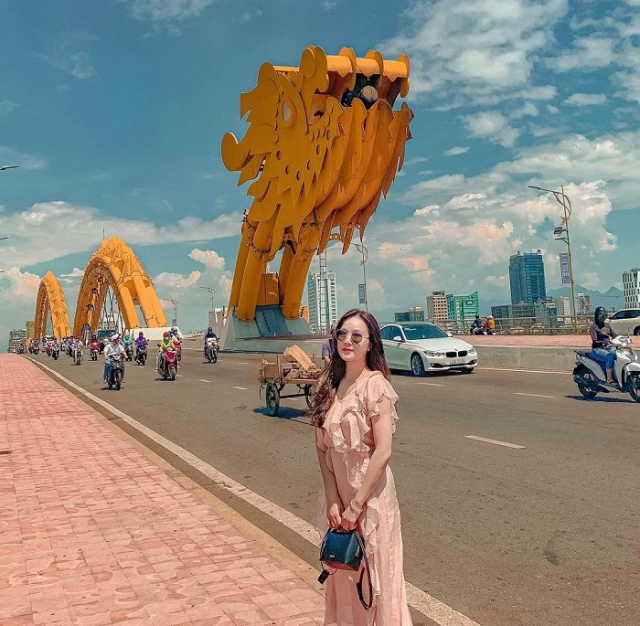

time: 242 ms (started: 2023-09-04 11:52:18 +00:00)


In [ ]:

######
#@title Display Sample Image. You can modify the path and try your own images!
######

# change path here for another image
img = cv2.imread("samples/dulich_dana.png")
img = imutils.resize(img, width=640)
cv2_imshow(img)

In [ ]:
img[:,:,1]

array([[ 40,  34,  38, ...,  89,  92, 135],
       [ 85,  48,  46, ...,  86,  85, 134],
       [ 69,  83,  79, ...,  89,  91, 134],
       ...,
       [ 95, 103, 105, ...,  67,  66,  66],
       [102, 105, 104, ...,  66,  66,  66],
       [103, 105, 104, ...,  64,  65,  65]], dtype=uint8)

time: 8.57 ms (started: 2023-09-04 09:35:28 +00:00)


The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime


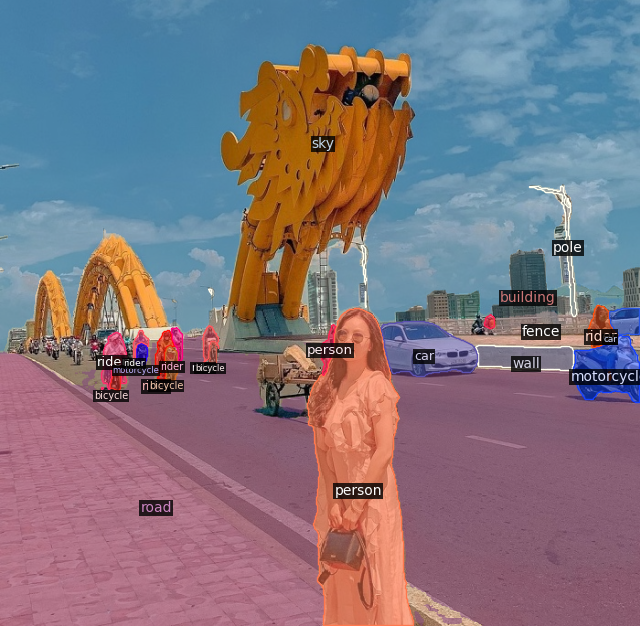

time: 1min 27s (started: 2023-09-04 11:56:04 +00:00)


In [ ]:
######
#@title Run Inference (CPU)
#@markdown Specify the **task**. `Default: panoptic`. Execution may take upto 2 minutes
######
###### Specify Task Here ######
task = "panoptic" #@param
##############################
%load_ext autotime
out = TASK_INFER[task](img, predictor, metadata).get_image()
cv2_imshow(out[:, :, ::-1])

In [ ]:
######
#@markdown We use `DiNAT-L` as the default backbone. To use Swin-L as backbone, select the checkbox below.
use_swin = True #@param {type: 'boolean'}

time: 742 µs (started: 2023-09-04 11:59:32 +00:00)


In [ ]:
######
#@title B. Initialize Model citycapes
######
# download model checkpoint
import os
import subprocess
if not use_swin:
  if not os.path.exists("250_16_dinat_l_oneformer_cityscapes_90k.pth"):
    subprocess.run('wget https://shi-labs.com/projects/oneformer/cityscapes/250_16_dinat_l_oneformer_cityscapes_90k.pth', shell=True)
  predictor, metadata = setup_modules("cityscapes", "250_16_dinat_l_oneformer_cityscapes_90k.pth", use_swin)
else:
  if not os.path.exists("250_16_swin_l_oneformer_cityscapes_90k.pth"):
    subprocess.run('wget https://shi-labs.com/projects/oneformer/cityscapes/250_16_swin_l_oneformer_cityscapes_90k.pth', shell=True)
  predictor, metadata = setup_modules("cityscapes", "250_16_swin_l_oneformer_cityscapes_90k.pth", use_swin)

In [ ]:
######
#@title Display Sample Image. You can modify the path and try your own images!
######

# change path here for another image
img = cv2.imread("samples/dulich_dana.png")
img = imutils.resize(img, width=512)
cv2_imshow(img)

In [ ]:
img[:,:,0]

array([[216, 248, 250, ..., 250, 250, 250],
       [131, 166, 227, ..., 250, 250, 250],
       [123, 123, 135, ..., 250, 250, 250],
       ...,
       [ 29,  29,  30, ..., 136, 135, 139],
       [ 30,  29,  29, ..., 139, 139, 139],
       [ 30,  30,  29, ..., 137, 133, 132]], dtype=uint8)

time: 5.82 ms (started: 2023-09-04 09:54:14 +00:00)


The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime


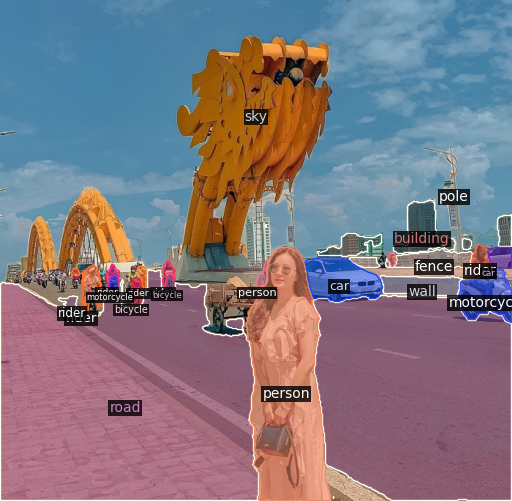

time: 1min 23s (started: 2023-09-04 12:00:16 +00:00)


In [ ]:
######
#@title Run Inference (CPU)
#@markdown Specify the **task**. `Default: panoptic`. Execution may take upto 2 minutes
######
###### Specify Task Here ######
task = "panoptic" #@param
##############################
%load_ext autotime
out = TASK_INFER[task](img, predictor, metadata).get_image()
cv2_imshow(out[:, :, ::-1])

In [ ]:
######
#@markdown We use `DiNAT-L` as the default backbone. To use Swin-L as backbone, select the checkbox below.
use_swin = False #@param {type: 'boolean'}

time: 620 µs (started: 2023-09-04 12:11:04 +00:00)


In [ ]:

######
#@title C. Initialize Model coco
######
# download model checkpoint
import os
import subprocess
if not use_swin:
  if not os.path.exists("150_16_dinat_l_oneformer_coco_100ep.pth"):
    subprocess.run('wget https://shi-labs.com/projects/oneformer/coco/150_16_dinat_l_oneformer_coco_100ep.pth', shell=True)
  predictor, metadata = setup_modules("coco", "150_16_dinat_l_oneformer_coco_100ep.pth", use_swin)
else:
  if not os.path.exists("150_16_swin_l_oneformer_coco_100ep.pth"):
    subprocess.run('wget https://shi-labs.com/projects/oneformer/coco/150_16_swin_l_oneformer_coco_100ep.pth', shell=True)
  predictor, metadata = setup_modules("coco", "150_16_swin_l_oneformer_coco_100ep.pth", use_swin)

[09/04 12:53:37 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from 150_16_dinat_l_oneformer_coco_100ep.pth ...


  text_encoder.positional_embedding
  text_encoder.transformer.resblocks.0.attn.{in_proj_bias, in_proj_weight}
  text_encoder.transformer.resblocks.0.attn.out_proj.{bias, weight}
  text_encoder.transformer.resblocks.0.ln_1.{bias, weight}
  text_encoder.transformer.resblocks.0.mlp.c_fc.{bias, weight}
  text_encoder.transformer.resblocks.0.mlp.c_proj.{bias, weight}
  text_encoder.transformer.resblocks.0.ln_2.{bias, weight}
  text_encoder.transformer.resblocks.1.attn.{in_proj_bias, in_proj_weight}
  text_encoder.transformer.resblocks.1.attn.out_proj.{bias, weight}
  text_encoder.transformer.resblocks.1.ln_1.{bias, weight}
  text_encoder.transformer.resblocks.1.mlp.c_fc.{bias, weight}
  text_encoder.transformer.resblocks.1.mlp.c_proj.{bias, weight}
  text_encoder.transformer.resblocks.1.ln_2.{bias, weight}
  text_encoder.transformer.resblocks.2.attn.{in_proj_bias, in_proj_weight}
  text_encoder.transformer.resblocks.2.attn.out_proj.{bias, weight}
  text_encoder.transformer.resblocks.2.ln_1

time: 7.65 s (started: 2023-09-04 12:53:34 +00:00)


In [ ]:
######
#@title Display Sample Image. You can modify the path and try your own images!
######

# change path here for another image
img = cv2.imread("samples/dulich_dana.png")
img = imutils.resize(img, width=512)
cv2_imshow(img)

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime


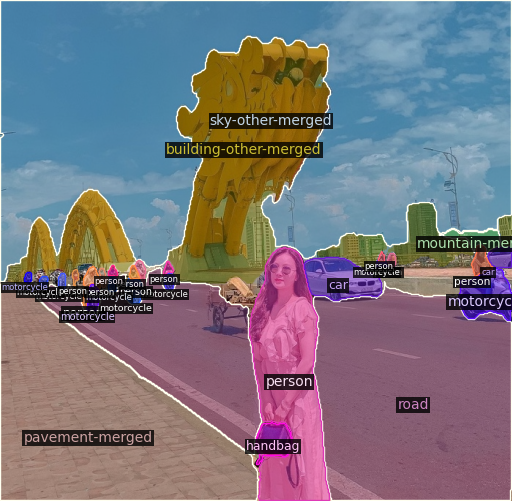

time: 59.7 s (started: 2023-09-04 12:53:52 +00:00)


In [ ]:
######
#@title Run Inference (CPU)
#@markdown Specify the **task**. `Default: panoptic`. Execution may take upto 2 minutes
######
###### Specify Task Here ######
task = "panoptic" #@param
##############################
%load_ext autotime
out = TASK_INFER[task](img, predictor, metadata).get_image()
cv2_imshow(out[:, :, ::-1])

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime


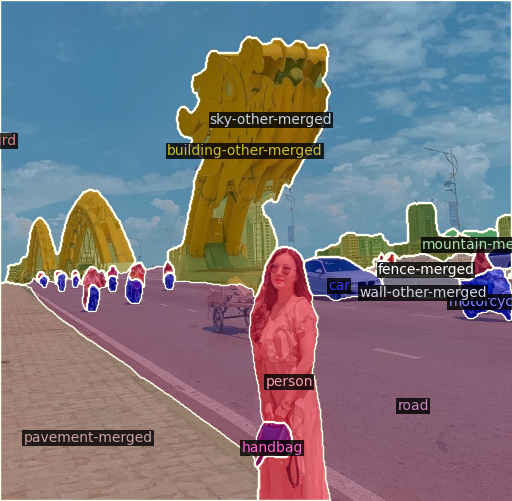

time: 1min (started: 2023-09-04 13:13:40 +00:00)


In [ ]:
task = "semantic" #@param
##############################
%load_ext autotime
out = TASK_INFER[task](img, predictor, metadata).get_image()
cv2_imshow(out[:, :, ::-1])

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime


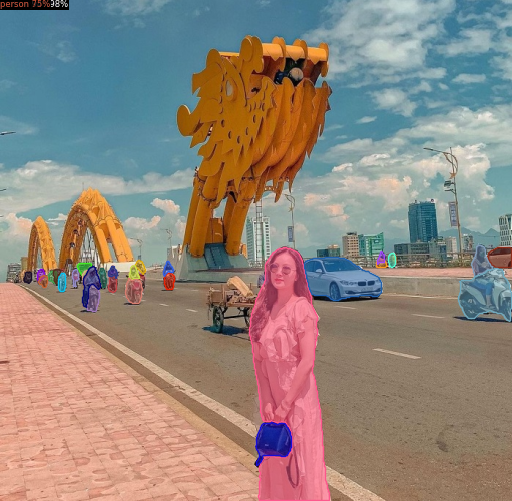

time: 59.1 s (started: 2023-09-04 13:28:52 +00:00)


In [ ]:
task = "instance" #@param
%load_ext autotime
out = TASK_INFER[task](img, predictor, metadata).get_image()
cv2_imshow(out[:, :, ::-1])